# Understanding RSC HD cells

In [1]:
import numpy as np
import matplotlib.pyplot as plt


## Visualizing Activity

1. There are 180 HD cells, each tuned to a preferred direction from 0 to 360 degree
2. Current direction is 0 degree

In [24]:
# parameters
num_cells = 180
preferred_directions = np.linspace(0, 360, num_cells)
current_direction = 0 
sigma = 10

def circular_gaussian(x, mu, sigma):
    # smallest angular distance between x and mu on a circle
    delta = np.angle(np.exp(1j * np.deg2rad(x - mu)), deg=True)
    return np.exp(-0.5 * (delta / sigma) ** 2)

In [25]:
preferred_directions.shape, preferred_directions.min(), preferred_directions.max()

((180,), np.float64(0.0), np.float64(360.0))

In [26]:
activity = circular_gaussian(preferred_directions, current_direction, sigma)

In [27]:
activity.min(), activity.max()

(np.float64(2.6803740442477085e-70), np.float64(1.0))

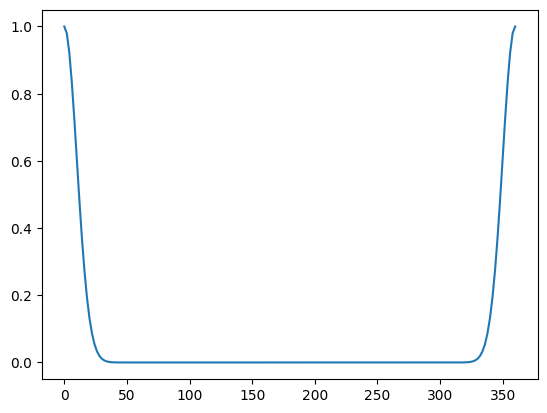

In [28]:
plt.plot(preferred_directions, activity)

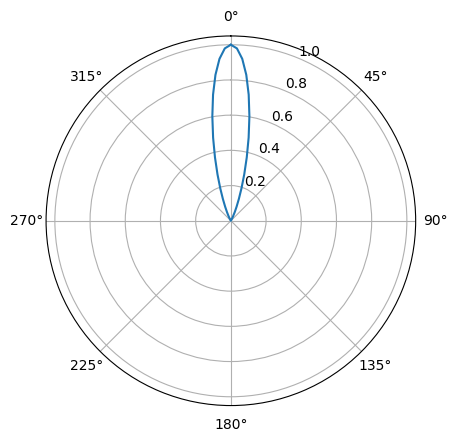

In [29]:
# polar plotting

theta = np.deg2rad(preferred_directions)
ax = plt.subplot(111, polar=True)
ax.plot(theta, activity)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

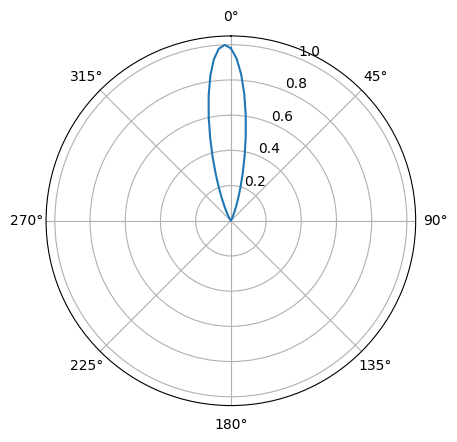

In [40]:
# animation of all angles
import matplotlib.animation as animation

def update(frame):
    current_direction = frame % 360
    activity = circular_gaussian(preferred_directions, current_direction, sigma)
    line.set_data(theta, activity)
    return line,

fig = plt.figure()
ax = plt.subplot(111, polar=True)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
line, = ax.plot([], [])

ani = animation.FuncAnimation(fig, update, frames=np.arange(0, 360, 2), interval=50, blit=True, repeat=True)
ani.save('rsc_hd.gif', writer='pillow', fps=20);

In [ ]:
# parameters
num_cells = 180
preferred_directions = np.linspace(0, 360, num_cells)
current_direction = 0 
sigma = 10

activity = circular_gaussian(preferred_directions, current_direction, sigma)

def update(frame):
    current_direction = frame % 360
    activity = circular_gaussian(preferred_directions, current_direction, sigma)
    line.set_data(theta, activity)
    return line,

fig = plt.figure()
ax = plt.subplot(111, polar=True)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
line, = ax.plot([], [])

ani = animation.FuncAnimation(fig, update, frames=np.arange(0, 360, 2), interval=50, blit=True, repeat=True)
ani.save('rsc_hd.gif', writer='pillow', fps=20);

### HD Cell Activity: Influencers

1. Its previous activity (decays over time)
2. Inhibition from other HD cells
3. Excitatory inputs from CONJ/ENV


Terms involved

1. Exponential decay
2. Inhibitory feedback
3. Input from CONJ/ENV
4. Input from ADN

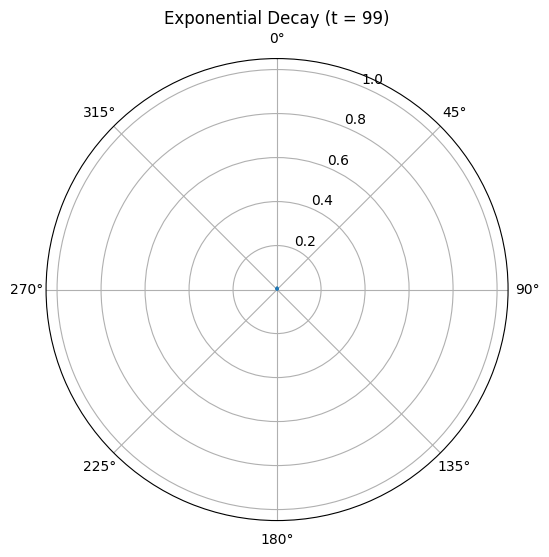

In [47]:
# Modelling only exponential decay

# Parameters
num_cells = 180
timesteps = 100
dt = 1.0
tau = 20.0
decay_factor = 1 - dt / tau
preferred_directions = np.linspace(0, 360, num_cells, endpoint=False)
theta = np.deg2rad(preferred_directions)

# Initial activity: Gaussian bump centered at 0 degree
sigma = 40
initial_direction = 0
activity = circular_gaussian(preferred_directions, initial_direction, sigma)

activity_over_time = [activity.copy()]
for t in range(1, timesteps):
    activity *= decay_factor
    activity_over_time.append(activity.copy())


activity_over_time = np.array(activity_over_time)

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
line, = ax.plot([], [], lw=2)

def update(frame):
    current_activity = activity_over_time[frame]
    line.set_data(theta, current_activity)
    ax.set_title(f"Exponential Decay (t = {frame})")
    return line,

ani = animation.FuncAnimation(
    fig, update,
    frames=timesteps,
    interval=100,
    blit=True,
    repeat=False
)
ani.save('rsc_hd_activity.gif', writer='pillow', fps=20);

Random walk for current direction

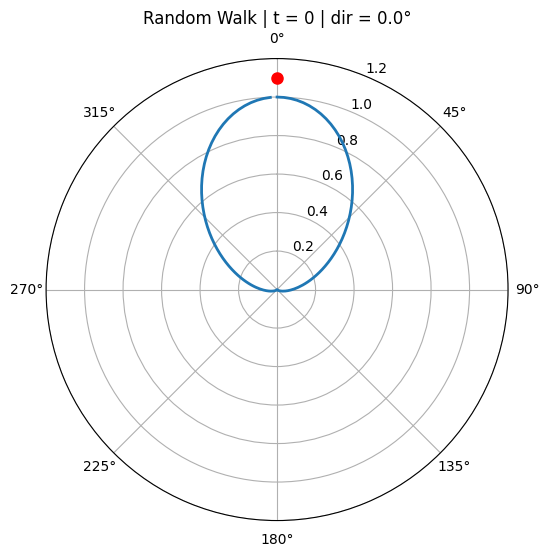

In [50]:
num_cells = 180
timesteps = 100
dt = 1.0
tau = 20.0
decay_factor = 1 - dt / tau
sigma = 40
step_size = 5 # maximum degrees change per time step in random walks

# Head direction cells
preferred_directions = np.linspace(0, 360, num_cells, endpoint=False)
theta = np.deg2rad(preferred_directions)

# Initial activity
current_direction = 0
activity = circular_gaussian(preferred_directions, current_direction, sigma)
activity_over_time = [activity.copy()]
direction_over_time = [current_direction]

# Simulate decay + random walk
for t in range(1, timesteps):
    # Random walk in circular space
    delta = np.random.uniform(-step_size, step_size)
    current_direction = (current_direction + delta) % 360
    direction_over_time.append(current_direction)

    # New bump location
    new_activity = circular_gaussian(preferred_directions, current_direction, sigma)
    activity = activity * decay_factor + new_activity * (1 - decay_factor)  # integrate both decay & input
    activity_over_time.append(activity.copy())

activity_over_time = np.array(activity_over_time)

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

# Setup
line, = ax.plot([], [], lw=2, label='HD Activity')
marker, = ax.plot([0], [0], 'ro', label='Input Direction', markersize=8)
ax.set_rlim(0, 1.2)  # Ensure room for the red dot

# Animation update
def update(frame):
    current_activity = activity_over_time[frame]
    line.set_data(theta, current_activity)

    # Update red dot showing input direction
    input_angle = np.deg2rad(direction_over_time[frame])
    marker.set_data([input_angle], [1.1])  # Keep just outside main ring

    ax.set_title(f"Random Walk | t = {frame} | dir = {direction_over_time[frame]:.1f}°")
    return line, marker


ani = animation.FuncAnimation(fig, update, frames=timesteps, interval=100, blit=False, repeat=False)
ani.save('rsc_hd_activity_randomwalk.gif', writer='pillow', fps=20);